In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from datetime import datetime
import json

time_format = "%d-%m-%Y_%H:%M:%S"
data_path = "./data"

<IPython.core.display.Javascript object>

In [3]:
# ---------------------------
# Load latest response json
# ---------------------------

from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
data_files = {}
for f in onlyfiles:
    datetime_object = datetime.strptime(f, time_format + ".json")
    data_files[datetime_object] = data_path + "/" + f

# TODO: load all the files in one go
latest_file = data_files[min(data_files.keys())]
with open(latest_file) as json_file:
    response = json.load(json_file)

<IPython.core.display.Javascript object>

In [4]:
# ---------------------------
# JSON to Dataframe
# ---------------------------

import pandas as pd
import json

searchJSON = response[-1]
for key, value in searchJSON.items():
    if key != "elementList":
        print(key, str(value))


searchJSON = []
for r in response:
    searchJSON.extend(r["elementList"])

print(len(searchJSON))
df = pd.DataFrame.from_dict(searchJSON)
print(df.columns.values)
df[
    [
        "address",
        "country",
        "district",
        "municipality",
        "neighborhood",
        "distance",
        "latitude",
        "longitude",
        "price",
        "size",
        "status",
        "priceByArea",
    ]
]

len(df)

total 1154
totalPages 24
actualPage 23
itemsPerPage 50
numPaginations 0
hiddenResults False
summary ['Comprar', 'Casas', 'distrito Santa Catarina, Misericórdia', 'Todos os preços', 'No último mes', '100 m² ou mais']
paginable True
upperRangePosition 1150
lowerRangePosition 1100
1150
['propertyCode' 'thumbnail' 'externalReference' 'numPhotos' 'floor'
 'price' 'propertyType' 'operation' 'size' 'exterior' 'rooms' 'bathrooms'
 'address' 'province' 'municipality' 'district' 'country' 'latitude'
 'longitude' 'showAddress' 'url' 'distance' 'hasVideo' 'status'
 'newDevelopment' 'hasLift' 'priceByArea' 'detailedType' 'suggestedTexts'
 'hasPlan' 'has3DTour' 'has360' 'hasStaging' 'topNewDevelopment'
 'parkingSpace' 'neighborhood' 'newDevelopmentFinished']


1150

<IPython.core.display.Javascript object>

In [5]:
# ---------------------------
# Remove outliers
# ---------------------------

min_quantile = 0.01
max_quantile = 0.99

df_no_outliers = df.loc[
    (df["size"] > df["size"].quantile(min_quantile))
    & (df["size"] < df["size"].quantile(max_quantile))
    & (df["priceByArea"] > df["priceByArea"].quantile(min_quantile))
    & (df["priceByArea"] < df["priceByArea"].quantile(max_quantile))
]
df_no_outliers = df_no_outliers[
    df_no_outliers["municipality"] != "Almada - Cova da Piedade - Pragal - Cacilhas"
]  # remove Almada!

<IPython.core.display.Javascript object>

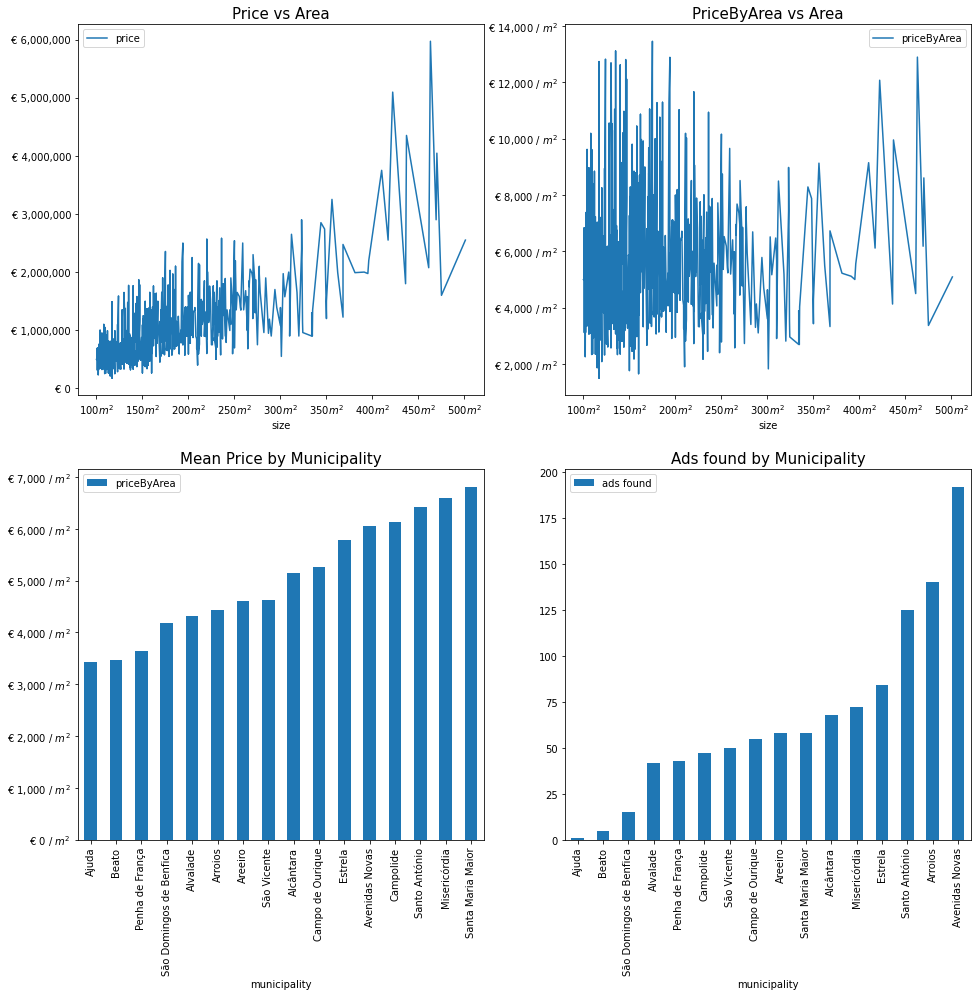

<IPython.core.display.Javascript object>

In [6]:
# ---------------------------
# Plot and sort values
# ---------------------------

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = [16, 15]
tick_square_meters = mtick.StrMethodFormatter("{x:,.0f}$m^2$")
tick_money_square_meters = mtick.StrMethodFormatter("€ {x:,.0f} / $m^2$")
tick_money = mtick.StrMethodFormatter("€ {x:,.0f}")

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].xaxis.set_major_formatter(tick_square_meters)
axes[0, 0].yaxis.set_major_formatter(tick_money)
axes[0, 1].xaxis.set_major_formatter(tick_square_meters)
axes[0, 1].yaxis.set_major_formatter(tick_money_square_meters)
axes[1, 0].yaxis.set_major_formatter(tick_money_square_meters)

axes[0, 0].set_title("Price vs Area").set_size(15)
df_no_outliers.sort_values(["size"]).plot(x="size", y="price", ax=axes[0, 0])
axes[0, 1].set_title("PriceByArea vs Area").set_size(15)
df_no_outliers.sort_values(["size"]).plot(x="size", y="priceByArea", ax=axes[0, 1])

df_grouped = df_no_outliers[["municipality", "priceByArea"]].groupby(["municipality"])

axes[1, 0].set_title("Mean Price by Municipality").set_size(15)
df_grouped.mean().sort_values(["priceByArea"]).plot(kind="bar", ax=axes[1, 0])
axes[1, 1].set_title("Ads found by Municipality").set_size(15)
ax = df_grouped.count().sort_values(["priceByArea"]).plot(kind="bar", ax=axes[1, 1])
ax = ax.legend(["ads found"])

In [ ]:
# ---------------------------
# Plot HeatMap
# ---------------------------

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

title_name = df['suggestedTexts'].apply(pd.Series).apply(lambda x: ' - '.join(x), axis=1)
#description = df.loc[:,['size','price','priceByArea','latitude','longitude']]
#description['size'] = description['size'].map(lambda x: "{:,.2f}m\u00b2".format(x))
#description['price'] = description['price'].map(lambda x: "€{:,.2f}".format(x))
#description['priceByArea'] = description['priceByArea'].map(lambda x: "€{:,.2f}".format(x))

fig = px.density_mapbox(df,
                        title='Heatmap of house prices',
                        lat='latitude', lon='longitude', z='priceByArea',
                        radius=10, zoom=11,
                        mapbox_style="stamen-terrain",
                        hover_name=title_name,
                        hover_data={
                            'size': ":,.2f",
                            'price': ":,.2f",
                            'priceByArea': ":,.2f", 
                            'latitude': False, 
                            'longitude': False
                        }
                       )
fig.show()


In [ ]:
# ---------------------------
# Remove Municipalities
# ---------------------------
import numpy as np

municipalities = df["municipality"].unique()

exclude = np.array(
    [
        # "São Vicente",
        "São Domingos de Benfica",
        # "Avenidas Novas",
        # "Arroios",
        "Penha de França",
        "Pontinha e Famões",
        # "Santo António",
        # "Belém",
        "Algés - Linda-a-Velha - Cruz Quebrada - Dafundo",
        "Odivelas",
        "Corroios",
        "Parque das Nações",
        # "Beato",
        "Benfica",
        # "Ajuda",
        # "Campo de Ourique",
        "Seixal - Arrentela - Aldeia de Paio Pires",
        "Lumiar",
        # "Campolide",
        "Olivais",
        # "Marvila",
        # "Areeiro",
        "Santa Maria Maior",
        "Charneca da Caparica e Sobreda",
        "Santa Clara",
        "Póvoa de Santo Adrião e Olival Basto",
        # "Alvalade",
        "Mina de Água",
        "Carnaxide e Queijas",
        # "Estrela",
        "Barreiro e Lavradio",
        "Encosta do Sol",
        "Amora",
        "Venteira",
        "Sacavém e Prior Velho",
        # "Misericórdia",
        "Moscavide e Portela",
        "Laranjeiro e Feijó",
        "Caparica e Trafaria",
        "Alto do Seixalinho - Santo André - Verderena",
        "Carnide",
        "Falagueira-Venda Nova",
        "Almada - Cova da Piedade - Pragal - Cacilhas",
        "Águas Livres",
    ]
)
municipalities = municipalities[~np.isin(municipalities, exclude)]

In [ ]:
# ---------------------------
# Plot HeatMap per Municipality
# ---------------------------

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import time


cols = 3
rows = math.ceil(len(municipalities) / cols)

data = []

layout = go.Layout(
    autosize=True,
    height=1500,
    title="Price by area",
    grid={"rows": rows, "columns": cols, "xgap": 0.1, "ygap": 0.2},
)

i = 0

for r in range(rows):
    if i == len(municipalities):
        break
    for c in range(cols):
        subplot_id = "mapbox" + str(i + 1)
        df_municipality = df[municipalities[i] == df["municipality"]]
        trace = go.Densitymapbox(
            name=municipalities[i],
            showlegend=True,
            lat=df_municipality["latitude"],
            lon=df_municipality["longitude"],
            z=df_municipality["priceByArea"],
            radius=10,
            hoverinfo="none",
            subplot=subplot_id,
            showscale=False,
        )
        # fig.add_trace(trace)
        data.append(trace)
        map_center = go.layout.mapbox.Center(
            lat=df_municipality["latitude"].mean(),
            lon=df_municipality["longitude"].mean(),
        )
        layout[subplot_id] = dict(
            style="carto-positron",  #'stamen-terrain',
            domain={"row": r, "column": c},
            center=map_center,
            zoom=12,
        )
        i = i + 1
        if i == len(municipalities):
            break

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
data = []

layout = go.Layout(
    autosize=True,
    height=700,
    title="Color ad by area",
    # grid={"rows": rows, "columns": cols, "xgap": 0.1, "ygap": 0.2},
)

for i in range(len(municipalities)):
    subplot_id = "mapbox" + str(i + 1)
    df_municipality = df[municipalities[i] == df["municipality"]]
    trace = go.Scattermapbox(
        name=municipalities[i],
        showlegend=True,
        lat=df_municipality["latitude"],
        lon=df_municipality["longitude"],
        mode="markers",
        marker=dict(size=14),
        text=municipalities[i],
        subplot="mapbox",
    )
    # fig.add_trace(trace)
    data.append(trace)

map_center = go.layout.mapbox.Center(
    lat=df["latitude"].mean(), lon=df["longitude"].mean()
)
layout["mapbox"] = dict(style="carto-positron", center=map_center, zoom=11,)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
# remove outliers from municipality
df_no_outliers_municipality = df_no_outliers[
    df_no_outliers.municipality.isin(municipalities)
]

df_grouped = (
    df_no_outliers_municipality[["municipality", "priceByArea", "price", "size"]]
    .groupby(["municipality"])
    .mean()
    .sort_values(["size"])
)
df_no_outliers[df_no_outliers.municipality.isin(municipalities)]


fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=df_grouped.index,
        y=df_grouped["size"],
        name="Size",
        yaxis="y1",
        marker_color="rgb(222,119,174)",
    )
)

# ------------------------------------- UGLY HACK (invisible bars so that the bars don't overlap)
dummy_y = [0] * len(df_grouped.index)
fig.add_trace(
    go.Bar(
        x=df_grouped.index, y=dummy_y, yaxis="y1", hoverinfo="none", showlegend=False,
    )
)

fig.add_trace(
    go.Bar(
        x=df_grouped.index, y=dummy_y, yaxis="y2", hoverinfo="none", showlegend=False,
    )
)
# ------------------------------------- UGLY HACK

fig.add_trace(
    go.Bar(
        x=df_grouped.index,
        y=df_grouped["price"],
        name="Price",
        yaxis="y2",
        marker_color="rgb(77,147,195)",
    ),
)


fig.update_layout(
    title="Size and Price per Municipality",
    yaxis2_tickformat=",",
    yaxis=dict(ticksuffix=" m<sup>2</sup>", title="Size",),
    yaxis2=dict(tickprefix="€ ", title="Price", side="right", overlaying="y",),
    barmode="group",
)

fig.show()